In [1]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import logsumexp
from scipy.special import eval_laguerre 
# Thank you Bastian for letting me use your ipynb as """inspiration"""
# Update: At this point, it looks nothing alike.

hbar = 1

In [54]:
class State():

    '''
    I've named the attributes and operations mostly according to the paper's naming scheme.
    I did do a few name changes here and there because I like it this way more.
    '''    
    def __init__(self, num_modes = 1, hbar = 1):
        """
        Initialize the states. Vacuum state by default
        
        Parameters
        -----------
        num_modes: Number of modes that the state has. Single (1) mode by default
        
        hbar: Planck's constant. hbar = 1 by default.
        """
        self.hbar = hbar
        self.num_modes = num_modes                                         # Me being ambitious and set an arbitrary # of modes. We'll prolly stick to 1
        self.means = np.array(np.zeros(self.num_modes*2))                  # Mean of the state, mu. zero'd by default. [x_i, p_i]
        self.covs = np.array(np.eye(self.num_modes*2)) * self.hbar/2       # Covariance matrix of the state. hbar/2 * I by default
        self.weights = np.array([1])                                       # It's just a single state by default. e^(w_kl)
        self.log_weights = np.array([0])                                   # Take the ln of the weights. so zero. w_kl
        self.num_weights = len(self.weights)                               # Number of weights. Used for size
        self.num_k = self.num_weights                                      # The number of terms we need to sum up from eq. (21)
        self.covDet = np.linalg.det(2*np.pi*self.covs)                     # Storing it beforehand so it's faster to calc.
        self.covInv = np.linalg.inv(self.covs)                             # Same as above
        self.norm = 1                                                      # I thought i didn't need it because "duh obviously it'll be normalized". Turns out not necessarily
        #self.psi = np.zeros((1,)*num_modes)                               # Tracking the states that we have in the Fock basis? Vacuum by default

    def Update(self, data):
        """
        data = [means, covs, log_weights, num_k]
        """
        if len(data) != 4:
            raise ValueError('Oops, you done fucked up now. It should be exact FOUR values. ')
        
        self.means, self.covs, self.log_weights, self.num_k = data
        self.num_weights = len(self.weights)
        self.num_modes = int(np.shape(self.means)[-1]/2)
        self.weights = np.exp(self.log_weights)
        self.num_weights = len(self.weights)
        self.covInv = np.linalg.inv(self.covs)
        self.covDet = np.linalg.det(2*np.pi*self.covs)
        self.normalize
    
    def get_norm(self):
        """
        Straight from Olga's code
        Calculate the norm by adding the weights together
        """
         
        log_norm = logsumexp(self.log_weights)

        if self.num_k != self.num_weights:
            self.log_norm = log_norm
            self.norm = np.exp(log_norm).real

        else:   
            self.log_norm = log_norm
            self.norm = np.real_if_close(np.exp(log_norm))

    def normalize(self):
        """
        Straight from Olga's code
        Subtract norm from log_weights
        """
        if self.num_k != self.num_weights:
            self.log_weights -= np.log(self.norm) 
        else:
            self.log_weights -= self.log_norm 
            
        self.weights /= self.norm

        self.get_norm() #Populate norm

    def ApplyOp(self, F, d, mode_indices=None):
        """
        Applies an operation to specified modes
        Parameters
        ----------
        F : array_like
            Symplectic matrix (2x2 for single mode, 2Nx2N for multi-mode)
        d : array_like
            Displacement vector (applied to each row of means if means is 2D)
        mode_indices : int or list, optional
            Index/indices of modes to apply operation to (None = all modes)
        """
        if mode_indices is None:
            # Apply to all modes if indices not specified
            self.covs = F @ self.covs @ F.T
            
            # Handle means displacement properly for both 1D and 2D cases
            if self.means.ndim == 1:
                self.means = F @ self.means + d
            else:
                # For multiple rows in means (shape (n, 2N))
                self.means = (F @ self.means.T).T + d  # Apply F to each row and add d
            
        else:
            # Convert single index to list if needed
            if isinstance(mode_indices, int):
                mode_indices = [mode_indices]
            
            # Create full transformation matrix
            full_F = np.eye(2*self.num_modes)
            full_d = np.zeros(2*self.num_modes)
            
            # For each target mode, embed its operation
            for i in mode_indices:
                start, end = 2*i, 2*(i+1)
                full_F[start:end, start:end] = F
                full_d[start:end] = d
                
            # Apply the embedded operation
            self.covs = full_F @ self.covs @ full_F.T
            
            # Handle means displacement properly for both 1D and 2D cases
            if self.means.ndim == 1:
                self.means = full_F @ self.means + full_d
            else:
                # For multiple rows in means (shape (n, 2N))
                self.means = (full_F @ self.means.T).T + full_d

        # Update cached properties
        #self.covInv = np.linalg.inv(self.covs)
        #self.covDet = np.linalg.det(2*np.pi*self.covs)
        data = self.means, self.covs, self.log_weights, self.num_k
        self.Update(data)

    def ApplyOp2(self, F, d, mode_indices):
        """
        Applies a two-mode operation to specified pairs of modes.
        
        Parameters
        ----------
        F : np.ndarray (4x4)
            Symplectic matrix for the two-mode operation.
        d : np.ndarray (length 4)
            Displacement vector for the two-mode operation.
        mode_indices : tuple or list of 2 ints
            Indices of the two modes to apply the operation to (e.g., (0, 1)).
        """
        if len(mode_indices) != 2:
            raise ValueError("mode_indices must specify exactly 2 modes.")
        
        i, j = sorted(mode_indices)  # Ensure i < j for consistency
        
        # Embed the two-mode operation into the full system
        full_F = np.eye(2 * self.num_modes)
        full_d = np.zeros(2 * self.num_modes)
        
        # Indices for the two modes (xxpp ordering)
        idx_i = [2*i, 2*i + 1]
        idx_j = [2*j, 2*j + 1]
        target_indices = idx_i + idx_j
        
        # Embed F and d into the full system
        full_F[np.ix_(target_indices, target_indices)] = F
        full_d[target_indices] = d
        
        # Apply the embedded operation
        self.covs = full_F @ self.covs @ full_F.T
        self.means = full_F @ self.means + full_d
        
        # Update cached properties
        data = self.means, self.covs, self.log_weights, self.num_k
        self.Update(data)

    def ApplyLoss(self, etas, nbars):
        """
        Applies loss channels to each mode individually
        
        Parameters
        ------------
        etas (array): Transmittivities for each mode (0 < eta ≤ 1)
        nbars (array): Thermal photon numbers for each mode
        """

        n_etas = len(etas)
        n_nbars = len(nbars)
        if n_etas != self.num_modes or n_nbars != self.num_modes:
            raise ValueError("Number of etas and nbars must match num_modes")
        
        for i in range(self.num_modes):
            # Create single-mode loss transformation
            X_i = np.sqrt(etas[i]) * np.eye(2)
            Y_i = (self.hbar/2) * (1-etas[i]) * (2*nbars[i] + 1) * np.eye(2)
            
            # Apply to each mode using your existing infrastructure
            self.ApplyOp(X_i, np.zeros(2), mode_indices=i)
            
            # Add noise term directly to the covariance matrix
            start, end = 2*i, 2*i+2
            self.covs[start:end, start:end] += Y_i
    
    def ApplyGain(self, G):
        """
        It's like applying loss but slightly different
        """
        n_G = len(G)
        if n_G != self.num_modes:
            raise ValueError("Number of etas and nbars must match num_modes")
        
        for i in range(self.num_modes):
            # Create single-mode gain transformation
            X_i = np.sqrt(G[i]) * np.eye(2)
            Y_i = (self.hbar/2) * (G[i]-1) * np.eye(2)
            
            # Apply to each mode using your existing infrastructure
            self.ApplyOp(X_i, np.zeros(2), mode_indices=i)
            
            # Add Gain term directly to the covariance matrix
            start, end = 2*i, 2*i+2
            self.covs[start:end, start:end] += Y_i

    def add_state(self, data):
        """
        Add a state (can be single or multi-component Gaussian) to the current state.
        """
        new_mean, new_cov, new_log_weight, num_k = data

        current_dim = self.covs.shape[0]
        new_dim = new_cov.shape[0]
        total_dim = current_dim + new_dim
        
        # Create block diagonal covariance manually
        new_cov_full = np.zeros((total_dim, total_dim))
        
        # Current system indices
        current_idx = np.arange(current_dim)
        # New system indices  
        new_idx = np.arange(current_dim, total_dim)
        
        # Place covariances in their blocks
        new_cov_full[np.ix_(current_idx, current_idx)] = self.covs
        new_cov_full[np.ix_(new_idx, new_idx)] = new_cov
        
        # Handle means concatenation PROPERLY
        if self.means.ndim == 1:
            # Current state has single mean vector (1D)
            if new_mean.ndim == 1:
                # Both are 1D: simple concatenation
                new_means_full = np.concatenate([self.means, new_mean])
            else:
                # Current: 1D, New: 2D - tile current to match new's shape
                current_means_expanded = np.tile(self.means, (new_mean.shape[0], 1))
                new_means_full = np.hstack([current_means_expanded, new_mean])
                
        else:
            # Current state has multiple means (2D)
            if new_mean.ndim == 1:
                # Current: 2D, New: 1D - tile new to match current's shape
                new_mean_expanded = np.tile(new_mean, (self.means.shape[0], 1))
                new_means_full = np.hstack([self.means, new_mean_expanded])
            else:
                # Both are 2D - need outer product style concatenation
                # This is where your (3,4) issue came from!
                n_current = self.means.shape[0]
                n_new = new_mean.shape[0]
                
                # Create all combinations
                current_repeated = np.repeat(self.means, n_new, axis=0)
                new_tiled = np.tile(new_mean, (n_current, 1))
                
                new_means_full = np.hstack([current_repeated, new_tiled])
        
        # Handle log weights (outer product)
        if self.log_weights.ndim == 0:
            current_weights = np.array([self.log_weights])
        else:
            current_weights = self.log_weights
            
        if new_log_weight.ndim == 0:
            new_weights = np.array([new_log_weight])
        else:
            new_weights = new_log_weight
        
        # Outer product of weights
        new_log_weights_full = current_weights[:, np.newaxis] + new_weights
        new_log_weights_full = new_log_weights_full.flatten()
        
        # Update num_k
        if self.log_weights.ndim == 0:
            current_num_k = 1
        else:
            current_num_k = self.num_k
            
        new_num_k_full = current_num_k * num_k
        
        # Update state
        data = [new_means_full, new_cov_full, new_log_weights_full, new_num_k_full]
        self.Update(data)
        self.num_modes += 1

    def post_select_fock(self, mode, n, infidelity=1e-4, out=False):
        """
        Simulates Photon Number Resolving Detector.
        Parameters
        -----------
        mode         - Which mode we're measuring
        n            - How many photons did the detector read out
        infidelity   - degree of accuracy for Fock to Gauss conversion

        Returns:
            state with one less mode, with the removed mode being read out
        """
        # Convert from Fock to Coherent
        means_n, cov, w_kl, num_k = Fock2Coh(N=n, prox=infidelity, hbar=self.hbar)
        weights_n = w_kl  # Keep as array, do NOT sum here!

        # Indices for measured/remaining modes
        measured_indices = [2*mode, 2*mode + 1]
        remaining_indices = [i for i in range(2 * self.num_modes) if i not in measured_indices]

        # Partition covariance matrix
        sigma_AA = self.covs[np.ix_(remaining_indices, remaining_indices)]
        sigma_AB = self.covs[np.ix_(remaining_indices, measured_indices)]
        sigma_BB = self.covs[np.ix_(measured_indices, measured_indices)]
        mu_A = self.means[remaining_indices]
        mu_B = self.means[measured_indices]

        new_means = np.zeros((len(means_n), len(mu_A)), dtype=complex)
        gammas = np.zeros(len(means_n), dtype=complex)  

        C = sigma_BB + cov
        C_inv = np.linalg.inv(C)
        sigma_A_prime = sigma_AA - sigma_AB @ C_inv @ sigma_AB.T

        for i, (alpha_mean, alpha_weight) in enumerate(zip(means_n, weights_n)):

            # Conditional mean and covariance
            new_means[i] = mu_A + sigma_AB @ C_inv @ (alpha_mean - mu_B)

            # Probability calculation
            diff = alpha_mean - mu_B

            # Calculating (gamma_mn), eq.(28)
            gammas[i] = np.log(((2*np.pi*self.hbar)**mode) * np.exp(-0.5 * diff.T @ (C_inv) @ diff) / np.sqrt(np.linalg.det(2 * np.pi * C)))


        prefactor = np.log(2*np.pi*self.hbar / np.sqrt(np.linalg.det(2*np.pi* C)))

        # Output the corrected weights
        gammas = gammas + prefactor + w_kl + self.log_weights
        #combined_mu = np.sum([p * m for p, m in zip(probs, new_means)], axis=0) / total_prob
        combined_mu = np.array(new_means)

        data = [combined_mu, sigma_A_prime, gammas, num_k]
        self.Update(data)
        self.get_norm()

    # Original. Probably not as numerically stable as Olga's since I use np.exp() a lot
    # Don't ever touch this. As far as I can tell, this works.
    def get_wigner(self, x, p):
        """
        Wigner function calculation that properly handles the w_kl weights
        for both diagonal (k=l) and cross (k!=l) terms
        """
        X, P = np.meshgrid(x, p)
        grid_points = np.stack([X.ravel(), P.ravel()], axis=-1)
        
        # Handle single Gaussian case
        if len(self.log_weights) == 1:
            diff = grid_points - self.means
            exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, self.covInv, diff)
            print("Jester")
            return (1/np.sqrt(self.covDet)) * np.exp(exponent).reshape(X.shape)
            
        
        # Multiple components case
        N = self.num_k
        # Reconstruct the full (k,l) indices in the same order as Fock2Coh
        k_indices = np.concatenate([np.arange(N), np.triu_indices(N, 1)[0]])
        l_indices = np.concatenate([np.arange(N), np.triu_indices(N, 1)[1]])
        W = np.zeros_like(X, dtype=complex)
        # Precompute inverse covariance and determinant
        #inv_sigma = np.linalg.inv(self.covs[0] if len(self.covs.shape) == 3 else self.covs)
        #det_sigma = np.linalg.det(2*np.pi*self.covs[0]) if len(self.covs.shape) == 3 else self.covDet
        inv_sigma = self.covInv
        det_sigma = self.covDet
        norm_const = 0

        for i in range(len(self.log_weights)):
            k = k_indices[i]
            l = l_indices[i]
            weight = np.exp(self.log_weights[i])
            
            # Calculate Gaussian component
            diff = grid_points - self.means[i]
            exponent = -0.5 * np.einsum("ni,ij,nj->n...", diff , inv_sigma , diff)
            G = (1/np.sqrt((det_sigma))) * np.exp(exponent).reshape(X.shape)
            if k == l:  # Diagonal term
                W += weight * G
                norm_const += weight
            else:  # Cross term
                W += 2 * (weight * G).real
                norm_const += 2 * weight.real
        
        W = W / norm_const
        return W

In [21]:
import scipy as sp

# Generic functions
def indices(N):
    """
    Generates the indexes k and l
    So that I don't have to write a double for loop everytime 
    Generated the pairs of upper-triag indices.
    """
    max = N+1
    k, l = np.triu_indices(max,1)
    k = np.concatenate([range(max),k])
    l = np.concatenate([range(max),l])

    return k, l

def Fock2Coh(N, prox, epsilon = None, hbar = 1):
    """
     Written by me (I'm serious) (With some inspiration from Olga)
        
    Converts from Fock state to a superposition of Gaussian states
    Follows eq. (18) and eq. (19) from Olga Solodovnikova

    Always, ALWAYS define hbar. THATS WHAT 6 HOURS OF DEBUGGING TAUGHT ME

    Parameters
    -----------
    N - Fock number state
    prox - For estimating parameter epsilon. Follows eq. (44)
    """
    cov = 0.5*hbar*np.eye(2)
    factor = 2*1j*np.pi/(N+1)
    k, l = indices(N)

    # From the paragraph after eq. (44), about how F scales with epsilon
    if epsilon is None:
        epsilon = (factorial(2*N+1)/(factorial(N)) * prox)**(1/(2*(N+1)))

    alpha_k = epsilon * np.exp( factor * k )
    alpha_l = epsilon * np.exp( factor * l)

    sum_states = alpha_k + alpha_l
    diff_states = alpha_k - alpha_l
    mu = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*diff_states.imag,
            sum_states.imag + 1j*(-diff_states.real)
        ])
    d_kl = -0.5*diff_states.imag**2 - 0.5*diff_states.real**2 - 1j*alpha_l.imag*alpha_k.real + 1j*alpha_k.imag*alpha_l.real
    w_kl = d_kl - factor * N * (k-l)

    # Number of terms in the first sum in eq. 21
    num_k = N + 1
    return mu.T, cov, w_kl, num_k

def prepare_fock_coherent(n, prox=1e-4, epsilon = None, hbar = 1):
    """
    Basically identical to Olga's function.
    Not much to change. Just makes life easier.
    Prepare Fock state in coherent state approx
    """

    data = Fock2Coh(n, prox, epsilon, hbar)
    fock = State(1)
    fock.Update(data)
    return fock

def CohSqz(r, alpha_k, alpha_l, hbar):
    """ 
    Uses Appendix A of https://arxiv.org/abs/2103.05530 to calc. the alphas
    Very similar to Fock2Coh, just slightly different alpha_k and alpha_l
    """

    cov = 0.5 * hbar * np.array([[np.exp(-2*r),0],[0,np.exp(2*r)]])
    alpha_k = alpha_k/(np.cosh(r)+np.sinh(r))
    alpha_l = alpha_l/(np.cosh(r)+np.sinh(r))


    sum_states = alpha_k + alpha_l
    diff_states = alpha_k - alpha_l

    mu = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*np.exp(-2*r)*diff_states.imag,
            sum_states.imag + 1j*np.exp(2*r)*(-diff_states.real)
        ])
    
    d_kl = -0.5*np.exp(-2*r)*diff_states.imag**2 - 0.5*np.exp(2*r)*diff_states.real**2 - 1j*alpha_l.imag*alpha_k.real + 1j*alpha_k.imag*alpha_l.real

    return mu, cov, d_kl

def gen_sqz_cat_coherent(r, alpha, k, hbar):
    """
    Generates cat states
    |psi> = N * ( |α⟩ ± |-α⟩ )

    It's a superposition of Gaussian states
    So we go by eq. (17), (18), (19)

    Mostly just from Olga's code

    Parameters
    -----------
    r     - Sqz strength. 0 for no squeezing. Duh.  
    alpha - displacement
    k     - parity. 0 for even, 1 for odd
    """
    # Define the components with proper coefficients
    params = [(1.0, alpha,alpha), (1.0,-alpha,-alpha), (2.0*(-1)**k,alpha,-alpha)]
    
    means = []
    log_weights = []

    for a in params:
        mu, cov, log_w = CohSqz(r, a[1], a[2], hbar)
        means.append(mu)
        log = log_w + np.log(np.abs(a[0]))
        if np.sign(a[0]) == -1:
            log += 1j * np.pi  # For negative coefficients
        log_weights.append(log)
    
    data = (np.array(means), cov, np.array(log_weights), 2 )
    return data

def prepare_sqz_cat_coherent(r, alpha, k, hbar):
    """
    Identical to Olga's code. Not much to change. I just took out the fast option.
    Prepare a squeezed cat, requires a higher precision
    
    Parameter
    ----------
    r     - Sqz strength. 0 for no squeezing. Duh.  
    alpha - displacement
    k     - parity. 0 for even, 1 for odd
    
    Returns
    ----------
        State
    """
    data = gen_sqz_cat_coherent(r, alpha, k, hbar)
    
    sq_cat = State(1)
    sq_cat.Update(data)
    return sq_cat

def fock_sprPos_Cohr(coeffs, prox=1e-4, epsilon = None, hbar = 1):
    '''
    For Converting Fock states into a superposition of Gaussian states
    Follows eq. (48), (49), (17), (18), (19)
    Parameters
    -----------
    coeffs  - coefficient of the Fock states. [a0, a1, a2, ...]
    prox    - Infidelity approximation
    epsilon - Circle radius type shihh
    
    Returns:
        means, covs, log_weights, num_k
    '''

    # Max # of photons
    N = len(coeffs) - 1
    factor = 2*1j*np.pi / (N+1)
    c = np.zeros(len(coeffs), dtype=complex)      # Holding the alpha coefficients
    covs = 0.5*hbar*np.eye(2)

    # From the paragraph after eq. (49), about how F scales with epsilon
    if epsilon is None:
        epsilon = (factorial(N+1)*prox)**(1/(2*(N+1)))

    for k in range(N+1):
        for l in range(N+1):
            c[k] += np.sqrt(factorial(l)) * coeffs[l] * np.exp(-factor*k*l*N) / (epsilon**l)
    c = np.log(c)
    k, l = indices(N)

    alpha_k = epsilon * np.exp( factor * k )
    alpha_l = epsilon * np.exp( factor * l)
    
    sum_states = alpha_k + alpha_l
    diff_states = alpha_k - alpha_l
    mu = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*diff_states.imag,
            sum_states.imag + 1j*(-diff_states.real)
        ])
    # d - log_coeff
    d_kl = -0.5*diff_states.imag**2 - 0.5*diff_states.real**2 - 1j*alpha_l.imag*alpha_k.real + 1j*alpha_k.imag*alpha_l.real
    log_weights = d_kl
    #log_weights[N+1:] += np.log(2)
    num_k = N + 1

    # From the paragraph after eq. 20
    log_weights += c[l] + np.conjugate(c[k])
    return mu.T, covs, log_weights, num_k

def prepare_sprPos_Fock(coeffs, prox, hbar = 1, epsilon = None):
    """
    Prepare a superposition of Fock states
    
    Parameter
    ----------
    coeffs    - coefficient of the Fock states. [a0, a1, a2, ...]  
    prox      - 
    
    Returns
    ----------
        State
    """
    data = fock_sprPos_Cohr(coeffs, prox, epsilon, hbar)
    
    fck_spr = State(1)
    fck_spr.Update(data)
    return fck_spr

def wigner_fock(n, x, y):

    factor1 = ((-1)**n)/np.pi 
    factor2 = np.exp(-x**2 - y**2)
    L = eval_laguerre(n, 2*x**2 + 2*y**2) 
    return factor1 * factor2 * L

# Photon number distribution in case anyone wants to do that.
def Wmn(m, n, x, p):
    if m < n:
        return np.conj(Wmn(n, m, x, p))  # Use symmetry
    else:
        # Calculate the generalized Laguerre polynomial
        L = sp.special.genlaguerre(n, m-n)(2*x**2 + 2*p**2)
        return (1/np.pi) * np.exp(-x**2 - p**2) * (-1)**n * (x - 1j*p)**(m-n) * np.sqrt(2**(m-n) * sp.special.factorial(n) / sp.special.factorial(m)) * L

def wigner2rho(W, size_limit, x, p):
    # Compute density matrix
    rho = np.zeros((size_limit, size_limit), dtype=complex)
    W = W.real
    for m in range(size_limit):
        for n in range(size_limit):
        # Integrate the Wigner function with the Wmn function
            integral = np.sum(W * Wmn(m, n, X, P)) * (x_step) * (p_step)
            rho[m, n] = 2 * np.pi * integral

    # Display Photon Number Statistics
    number_values = np.arange(0, size_limit)
    number_prob = [rho[m, m] for m in range(size_limit)]

    return number_values, number_prob



In [59]:
# Gaussian Operations
# Squeezing Op.
def Sqz(r, phi):
    return np.cosh(r)*np.eye(2) - np.sinh(r)*np.array([[np.cos(phi), np.sin(phi)],[np.sin(phi),-np.cos(phi)]])
d_squeezing = np.zeros(2)  # No displacement for squeezing

# Displacement Op.
F_Displacement = np.eye(2)
def Displacement(alpha):
    return np.sqrt(2*hbar)*np.array([alpha.real, alpha.imag])

# Beam splitter Op.
# Knicked this from Olga's code
def beam_splitter(theta, phi):
    cp = np.cos(phi)
    sp = np.sin(phi)
    
    cs = np.cos(theta) * np.eye(2)
    ss = np.sin(theta) * np.array([[cp, -sp], [sp, cp]])
    return np.block([[cs, -ss.T],[ss, cs]])
d_bs = np.zeros(4)

def two_mode_squeezing(r, phi):
    c = np.cos(phi)
    s = np.sin(phi)

    Sphi = np.array([[c, s], [s, -c]])
    return np.block([[np.cosh(r)*np.eye(2), np.sinh(r) * Sphi], [np.sinh(r)*Sphi, np.cosh(r)*np.eye(2)]])
d_tms = np.zeros(4)

In [5]:
# Muh Plotting Functions
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_wigner_with_marginals_2D(W, x, p, title=None, figsize=(6, 6)):
    """
    Olga's plot looked too good to not "borrow" her style.

    Wigner function plot with marginals
    
    Parameters:
        W (array): 2D Wigner function values (shape: len(p) x len(x))
        x (array): Position coordinates
        p (array): Momentum coordinates
        title (str): Optional plot title
        figsize (tuple): Figure size
    """
    # Calculate marginals
    marginal_x = np.sum(W, axis=0) * np.diff(p)[0]
    marginal_p = np.sum(W, axis=1) * np.diff(x)[0]
    
    # Create figure with adjusted dimensions
    fig = plt.figure(figsize=figsize)
    
    # Create gridspec with space for colorbar
    gs = fig.add_gridspec(2,3,  width_ratios=(1,4,0.25), height_ratios=(1,4),
                          left=0.12, right=0.85, bottom=0.22, top=0.9,
                          wspace=0.1, hspace=0.1, )
    
    # Create axes with shared axes
    ax = fig.add_subplot(gs[1, 1])  # Main plot
    ax_x = fig.add_subplot(gs[0, 1], sharex = ax)
    ax_p = fig.add_subplot(gs[1, 0], sharey = ax)
    cax = fig.add_subplot(gs[1,2])
    # Plot Wigner function

    W = W.real
    scale = np.max(W)
    nrm = mpl.colors.Normalize(-scale, scale)
    extent = np.array([np.min(x), np.max(x), np.min(p), np.max(p)])
    im = ax.imshow(W, cmap='RdBu', norm = nrm, extent = extent, interpolation = 'bilinear')
    ax.set_aspect("equal")

    # Plot marginals
    ax_x.plot(x, marginal_x.real , 'b-', linewidth=1.5)
    ax_p.plot(marginal_p.real, p, 'b-', linewidth=1.5)

    ax.set_xlabel(r"$x$")
    ax_p.set_ylabel(r"$p$")

    # Formatting
    ax.set_xlabel('X')
    ax_p.set_ylabel('P')
    ax_x.set_ylabel('P(x)')
    ax_p.set_xlabel('P(p)')
    
    # Adjust marginal plot directions
    ax_p.invert_xaxis()
    
    # Set matching limits
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(p.min(), p.max())
    
    # Remove duplicate ticks
    plt.setp(ax_x.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    
    # Add colorbar to dedicated axis
    plt.colorbar(im, cax = cax )
    
    if title:
        fig.suptitle(title, y=0.95)
    
    return

def plot_wigner_3d_with_projections(W, x, p, title=None, figsize=(8, 6)):
    """
    3D Wigner function with contour projections on walls
    
    Parameters:
        W (array): 2D Wigner function values (shape: len(p) x len(x))
        x (array): Position coordinates
        p (array): Momentum coordinates
        title (str): Optional title
        figsize (tuple): Figure size
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Create grid
    X, P = np.meshgrid(x, p)
    W_real = W.real
    
    # Calculate offsets (10% beyond data range)
    z_offset = np.min(W_real) - 0.1*np.ptp(W_real)
    x_offset = np.min(x) - 0.1*np.ptp(x)
    y_offset = np.max(p) + 0.1*np.ptp(p)
    
    # Plot surface
    surf = ax.plot_surface(X, P, W_real, cmap='RdBu',
                         edgecolor='royalblue', lw=0.5,
                         rstride=8, cstride=8, alpha=0.3)
    
    # Plot projections on walls
    ax.contour(X, P, W_real, zdir='z', offset=z_offset, cmap='coolwarm', levels=10)
    ax.contour(X, P, W_real, zdir='x', offset=x_offset, cmap='coolwarm', levels=10)
    ax.contour(X, P, W_real, zdir='y', offset=y_offset, cmap='coolwarm', levels=10)
    
    # Styling
    ax.set(xlabel='X (Position)', ylabel='P (Momentum)', zlabel='W(q,p)')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    # Set limits to include projections
    ax.set(xlim=(np.min(x), np.max(x)),
          ylim=(np.min(p), np.max(p)),
          zlim=(z_offset, np.max(W_real)))
    
    if title:
        ax.set_title(title, pad=20)
    
    plt.tight_layout()
    return fig, ax

def plot_wigner_3D(W, x, p, title=None, figsize=(12, 8), cmap='RdBu'):
    """
    Simple 3D Wigner function ... plotting function?
    """

    # Create grid and ensure real values
    X, P = np.meshgrid(x, p)
    W = W.real
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    # Use proper surface plotting with colormap to show negativity
    surf = ax.plot_surface(X, P, W, cmap=cmap, 
                        rstride=1, cstride=1,
                        edgecolor='none', 
                        antialiased=True, vmin=np.min(W), vmax=np.max(W))

    ax.set_xlabel('X')
    ax.set_ylabel('P')
    ax.set_zlabel('W(q,p)')
    ax.set_zlim(-0.5, 0.5)  # Adjusted for better view of negativity
    if title:
        ax.set_title(title, pad=20)
    # Add colorbar to show negative values
    fig.colorbar(surf, shrink=0.5, aspect=5, label='Wigner Function Value')
    plt.tight_layout()
    plt.show()
    return 

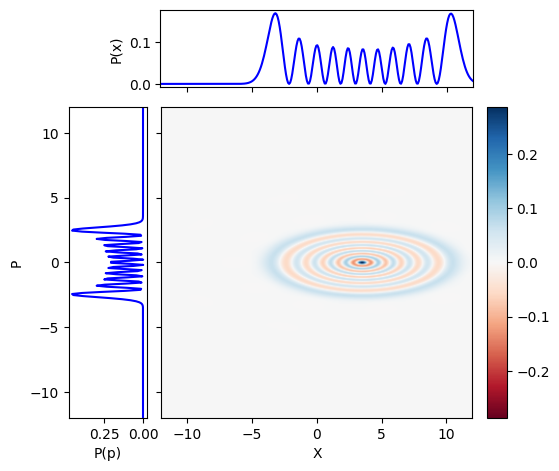

In [6]:
# Displaced, squeezed photon number state
r = 0.5
alpha = 2.5
fock = prepare_fock_coherent(10)

fock.ApplyOp(Sqz(r, np.pi), d_squeezing)
fock.ApplyOp(F_Displacement, Displacement(alpha))

x = np.linspace(-12,12,300)
Wfock_sq_disp = fock.get_wigner(x,x)

plot_wigner_with_marginals_2D(Wfock_sq_disp.real, x, x)

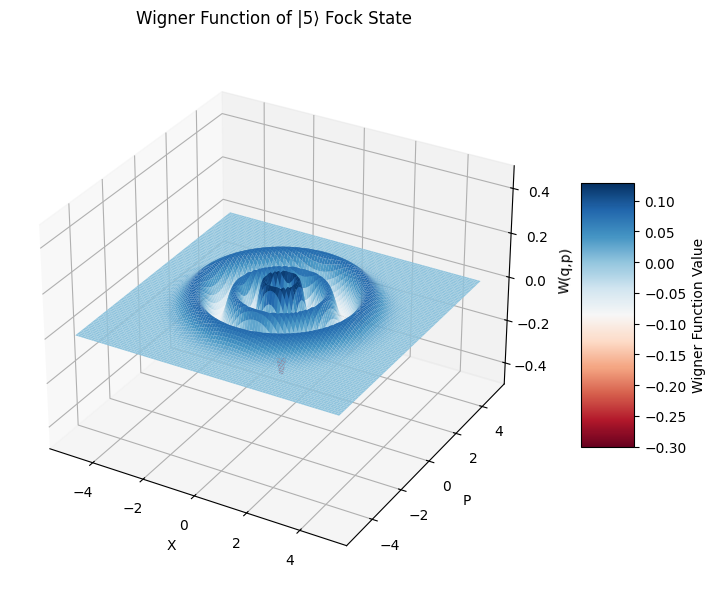

In [7]:
# Fock state as LCoG
N = 5
epsilon = 0.5
state = prepare_fock_coherent(N, 1, epsilon, hbar)
state.normalize

# Our (X,P) grid
x = np.linspace(-5, 5, 100)
p = np.linspace(-5, 5, 100)
W = state.get_wigner(x,x)

plot_wigner_3D(W, x, x, title=f'Wigner Function of |{N}⟩ Fock State', figsize=(9,6))
#plot_wigner_with_marginals_2D(W,x,x, title=f'Wigner Function of |{N}⟩ Fock State')

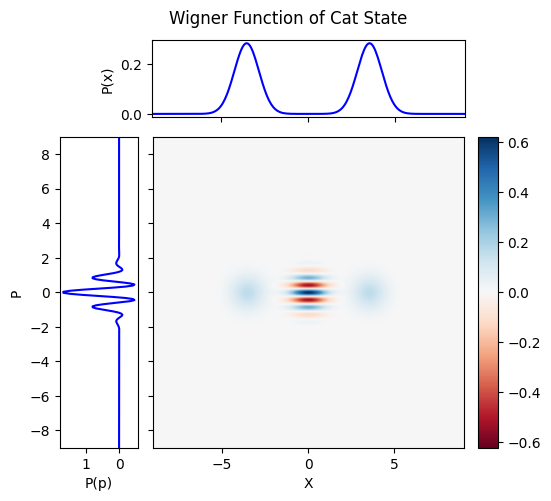

In [8]:
# Cat state
alpha = 5/2
r = 0
cat = prepare_sqz_cat_coherent(r, alpha*np.exp(r), 0, hbar)
cat.normalize
x = np.linspace(-9,9,300)
Wcat = cat.get_wigner(x,x)

plot_wigner_with_marginals_2D(Wcat.real,x,x, title=f'Wigner Function of Cat State')

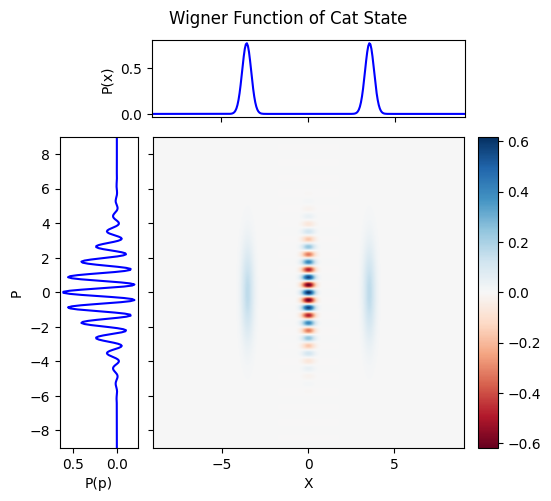

In [9]:
# Squeezed Cat state
alpha = 5/2
r = 1
cat = prepare_sqz_cat_coherent(r, alpha*np.exp(r), 0, hbar)
#cat.normalize
x = np.linspace(-9,9,300)
Wcat = cat.get_wigner(x,x)

#plot_wigner_3D(Wcat.real, x, x, title=f'Wigner Function of Squeezed Cat State', figsize=(8,6))
plot_wigner_with_marginals_2D(Wcat.real,x,x, title=f'Wigner Function of Cat State')


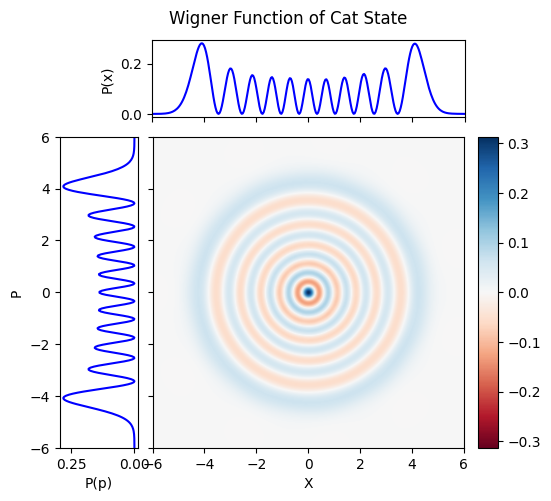

In [10]:
# 10 Photons state
fock = prepare_fock_coherent(10)

x = np.linspace(-6,6,300)
Wfock = fock.get_wigner(x,x)

#plot_wigner_3D(Wfock.real, x, x, title='10 Photons State', figsize = (8,6))
plot_wigner_with_marginals_2D(Wfock.real,x,x, title='Wigner Function of Cat State')

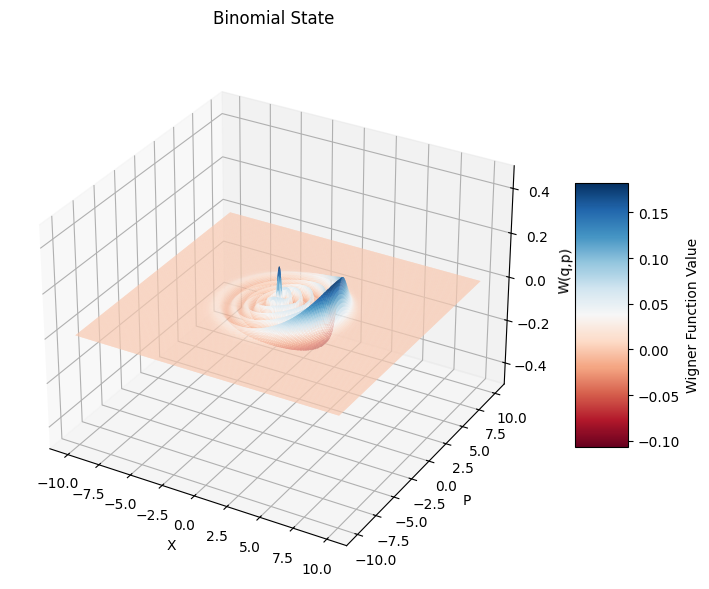

In [11]:
# Binomial state
from scipy.special import comb
def binom_coeffs(eta, M):
    ns = np.arange(M+1)
    return np.sqrt(comb(M,ns) * eta **ns * (1-eta)**(M-ns))

M = 10
eta = 0.95

fock_coeffs = binom_coeffs(eta, M)
#fock_coeffs = np.array([1,2,3])
binom = prepare_sprPos_Fock(fock_coeffs, 1e-4, hbar = 1)
x = np.linspace(-10,10,300)
Wbinom = binom.get_wigner(x,x)

plot_wigner_3D(Wbinom.real, x, x, title='Binomial State', figsize = (8,6))
#plot_wigner_with_marginals_2D(Wbinom.real,x,x, title='Binomial State')

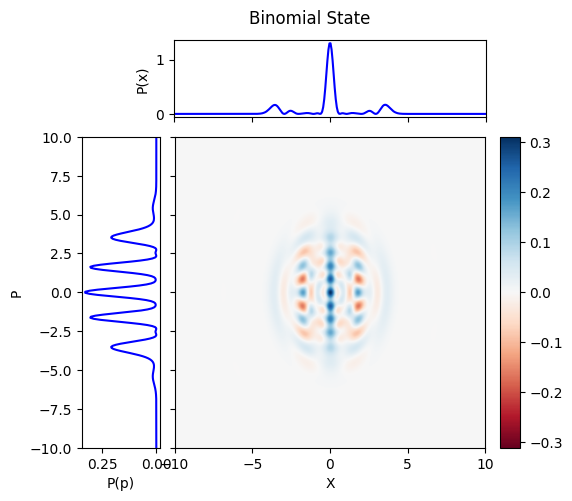

In [12]:
# The Walrus Attempt
fock_coeffs = [ 0.661, 0, -0.343, 0, 0.253, 0, -0.368, 0, 0.377, 0, 0.323, 0, 0.365 ] # In Fock basis
testy = prepare_sprPos_Fock(fock_coeffs, 1e-4, hbar = 1)
testy.ApplyOp(Sqz(0.196,0),d_squeezing)
x = np.linspace(-10,10,300)
Wt = testy.get_wigner(x,x)

# https://the-walrus.readthedocs.io/en/latest/gallery/gkp.html
# Not a complete failure but something is sus. I just can't put m finger on it.
#plot_wigner_3D(Wt.real, x, x, title='Attempted Sqz. Fock States in Superposition', figsize = (8,6))
plot_wigner_with_marginals_2D(Wt.real,x,x, title='Binomial State')

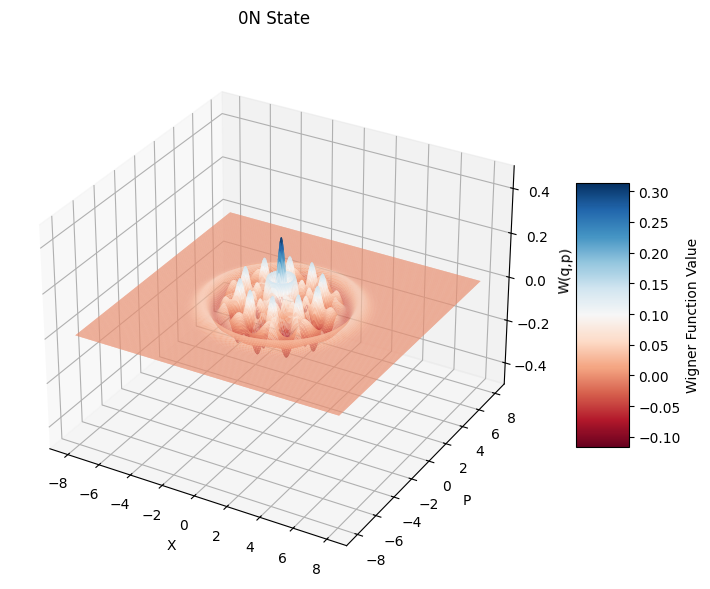

In [13]:
# 0N state
n = 10

fock_coeffs = np.zeros(n+1)
fock_coeffs[0] = 1
fock_coeffs[-1] = 1
on = prepare_sprPos_Fock(fock_coeffs, 1e-4, hbar = 1)
x = np.linspace(-8,8,300)
Won = on.get_wigner(x,x)

plot_wigner_3D(Won.real, x, x, title='0N State', figsize = (8,6))
#plot_wigner_with_marginals_2D(Won.real,x,x, title='0N State')

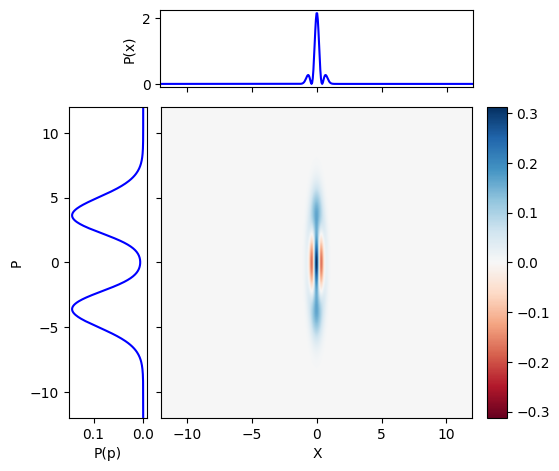

In [14]:
#Photon subtraction
theta = np.arccos(np.sqrt(0.99))
#theta = np.pi/4

n = 2
r = 1

state = State(2)
state.ApplyOp(Sqz(r, 0), d_squeezing, 0)
state.ApplyOp2(beam_splitter(theta, 0), d_bs, mode_indices=(0, 1))

state.post_select_fock(1, n)

x = np.linspace(-12,12,500)
Wsub = state.get_wigner(x,x)

plot_wigner_with_marginals_2D(Wsub, x, x)

0.1561806423672022


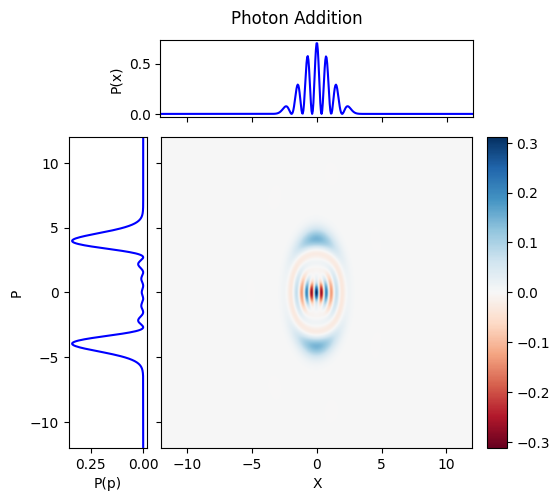

In [19]:
#Photon addition
state = State(2)
r = 1
r2 = 0.001
n = 2

r = 1
r2 = 1
n = 6

state.ApplyOp(Sqz(r,0), d_squeezing, 0)
state.ApplyOp2(two_mode_squeezing(r2,0), d_tms, mode_indices=(0,1))

state.post_select_fock(1,n, 1e-5)
print(state.norm)


x = np.linspace(-12,12,500)
W = state.get_wigner(x,x)

plot_wigner_with_marginals_2D(W,x,x, title = "Photon Addition")

### Everything below is still a work in progress

In [61]:
'''#Photon-added coherent state
# Not working at all. Something is wrong with add_state
state = State(1)
alpha = 0.5+0.5j
data = Fock2Coh(1,prox=1e-4)
state.add_state(data)
state.means.shape

state.ApplyOp(np.eye(2), Displacement(alpha), 0)
state.ApplyOp2(beam_splitter(np.pi/4,0), d_bs, mode_indices=(0,1))
state.post_select_fock(0,1)

x = np.linspace(-6,6,100)
W = state.get_wigner(x,x)
'''

'#Photon-added coherent state\n# Not working at all. Something is wrong with add_state\nstate = State(1)\nalpha = 0.5+0.5j\ndata = Fock2Coh(1,prox=1e-4)\nstate.add_state(data)\nstate.means.shape\n\nstate.ApplyOp(np.eye(2), Displacement(alpha), 0)\nstate.ApplyOp2(beam_splitter(np.pi/4,0), d_bs, mode_indices=(0,1))\nstate.post_select_fock(0,1)\n\nx = np.linspace(-6,6,100)\nW = state.get_wigner(x,x)\n'

In [15]:
# Kinda working. The heralding prob still needs work.
def herald_fock(r, n, eta, infid = 1e-4):
    #Make an EPR pair
    state = State(2)
    state.ApplyOp(Sqz(r, 0), d_squeezing, 0) #Squeeze mode 1 in x
    state.ApplyOp(Sqz(r, np.pi), d_squeezing, 1) #Squeeze mode 2 in p
    
    theta = np.pi/4
    state.ApplyOp2(beam_splitter(theta, 0), np.zeros(4), mode_indices=(0, 1)) #50:50 beamsplitter

    #Loss channel
    etas = np.array([1,eta]) #transmissivities of loss channel in each mode
    nbars = np.zeros(2) #thermal photon numbers
    state.ApplyLoss(etas, nbars) #apply the loss channel
    
    state.post_select_fock(1, n, infidelity = infid) #project mode 2 on Fock n
    return state

r = 1
n = 10 #photon number
eta = 1 #quantum efficiency of photon detector
state = herald_fock(r, n, eta)

Wfock = state.get_wigner(x,x)
num_weights_fock = state.num_weights
print('Heralding prob', state.norm)
def prob_fock(r,n):
    return np.tanh(r)**(2*n)/np.cosh(r)**2
    
print('Analytical prob', prob_fock(r,n))

# Displays the correct plot.
#plot_wigner_3D(Wfock, x, x)

Heralding prob 0.0590549897453238
Analytical prob 0.001810067685313628


In [64]:
from scipy.special import factorial, genlaguerre
def Dmn(alpha : complex, m : int, n : int) -> complex:
    """Calculates mn'th element of complex displacement operator with alpha using the Cahill1969 formula
    """
    
    
    if n > m:
        m, n = n, m
        alpha = -alpha.conjugate()

        
    prefactor = np.sqrt(factorial(n)/factorial(m)) * alpha**(m-n) * np.exp(-np.abs(alpha)**2 / 2)
    dmn = prefactor * genlaguerre(n, m-n)(np.abs(alpha)**2)

    return dmn


def density_mn(alpha : complex, cutoff : int) -> np.ndarray:
    """Construct Fock decomposition of the displacement operator up to a cutoff
    """
    if cutoff == 0:
        rho = Dmn(alpha, 0,0)
        
    else:
        rho = np.zeros((cutoff+1, cutoff+1), dtype = 'complex')
        
        for i in np.arange(cutoff+1):
            for j in np.arange(cutoff+1):
                rho[i,j] = Dmn(alpha, i,j)
    return rho

def get_gkp_squeezing_displacements(lattice, N=1):
    
    lattices = ['0', '1', 's0', 's1', 'h0', 'h1', 'hs0', 'hs1']
        
    if lattice not in lattices:
        raise ValueError('lattice must be either 0, 1, s0, s1, h0, h1, hs0 or hs1')


    if '0' in lattice: 
        coeffs = [4, -1, -1, -1, -1]
    elif '1' in lattice:
        coeffs = [4, -1, -1, 1, 1]
        
    if lattice == '0' or lattice =='1': #logical
    
        a1 = np.sqrt(2 * np.pi) 
        a2 = 1j * np.sqrt(np.pi/2)
                                                                                                        
        
    elif lattice == 's0' or lattice == 's1': #qunaught
        a1 = np.sqrt(np.pi)
        a2 = 1j*np.sqrt(np.pi)
        

    elif lattice == 'h0' or lattice == 'h1': #hexagonal logical
        kappa1 = 3**(-1/4) + 3**(1/4)
        kappa2 = 3**(-1/4) - 3**(1/4)
    
        a1 = np.sqrt(np.pi/2)*(kappa1 +1j*kappa2)
        a2 = np.sqrt(np.pi/8)*(kappa2 +1j*kappa1)


    elif lattice == 'hs0' or lattice == 'hs1': #hexagonal qunaught
        kappa1 = 3**(-1/4) + 3**(1/4)
        kappa2 = 3**(-1/4) - 3**(1/4)
        
        a1 = np.sqrt(np.pi)/2*(kappa1 + 1j*kappa2)
        a2 = np.sqrt(np.pi)/2*(kappa2 + 1j*kappa1)
        
    return a1*np.sqrt(N), a2*np.sqrt(N), coeffs


def gkp_nonlinear_squeezing_operator(cutoff, N=1, lattice = '0'):
    """Construct the GKP nonlinear squeezing operator in the Fock basis up to a cutoff for a type of GKP state
    """
    I = np.eye(cutoff+1, dtype='complex')
    a1, a2, coeffs = get_gkp_squeezing_displacements(lattice, N)
    alphas = [0, a1, -a1, a2, -a2]
    rho = 4*I
    for i, c in enumerate(coeffs):
        if i !=0:
            rho += c * density_mn(alphas[i], cutoff)

    return rho /2 #Norm wrt Gaussian limit

def gen_gkp_coherent(n, lattice, N = 1,inf = 1e-4, fast = False):
    """
    Returns state data for 
    Obtain best GKP state in coherent state decomp from the ground state of the GKP nonlinear squeezing operator
    Args: 
        n: Fock cutoff
        which: '0', '1', 's0', 's1', 'h'
        N: scaling of the grid
        inf: (in)fidelity of the coherent state approximation
    """
    rho = gkp_nonlinear_squeezing_operator(n, N, lattice)

    w, v = np.linalg.eigh(rho)
    
    coeffs = v[:,0] #eigs always sorted from lowest to highest eigenvalue, choose lowest
    
    data_gkp = fock_sprPos_Cohr(coeffs, inf)
  
    
    return data_gkp

def prepare_gkp_nonlinear_sqz(n, lattice, N = 1, inf = 1e-4, fast=True):
    """
    Obtain best GKP state in coherent state decomp from the ground state of the GKP nonlinear squeezing operator
    Args: 
        n: Fock cutoff
        lattice: '0', '1', 's0', 's1', 'h0', 'h1', 'hs0', 'hs1'
        N: scaling of the grid
        inf: infidelity of the coherent state approximation
    Returns:
        bosonicplus.base.State
    """
    
    data_gkp = gen_gkp_coherent(n, lattice, N, inf, fast)

        
    state = State(1)
    state.Update(data_gkp)
    
    return state
def rotation(phi):
    c = np.cos(phi)
    s = np.sin(phi)
    return np.array([[c, -s],[s,c]])

In [65]:
def print_test(n, lattice):
    
    print('GKP: ', lattice)
    
    gkp = prepare_gkp_nonlinear_sqz(n, lattice, fast=True)
    gkp.normalize()

    
    if lattice == '0' or lattice == '1':
        scalex =  np.sqrt(hbar*np.pi)
        scalep =  np.sqrt(hbar*np.pi)
        grid = 'rect'
        xlim = 4
        plim = 4
        
        
    elif lattice == 's0' or lattice == 's1':
        grid = 'square'
        scalex = np.sqrt(2*hbar*np.pi)
        scalep = np.sqrt(2*hbar*np.pi)
        xlim = 3
        plim = 3
       
        
    elif lattice == 'h0' or lattice == 'h1': 
        grid = 'hex'
        scalex = (3/4)**(1/4) * np.sqrt(hbar*np.pi)
        scalep = (4/3)**(1/4) * np.sqrt(hbar*np.pi)
        scale = 1
        xlim = 4
        plim = 4
        
        
        
    elif lattice == 'hs0' or lattice == 'hs1': 
        grid = 'hex_square'
        scalex = (3/4)**(1/4) * np.sqrt(2*hbar*np.pi)
        scalep = (4/3)**(1/4) * np.sqrt(2*hbar*np.pi)
        scale =1
        xlim = 3
        plim = 3


    if lattice in ['h0','h1', 'hs0', 'hs1'] :
        gkp.ApplyOp(rotation(-np.pi/12), d_squeezing, 0)


    x = np.linspace(-12,12,300)
    W = gkp.get_wigner(x,-x).real
    plot_wigner_with_marginals_2D(W,x,x)
    
    return 
      
    

GKP:  0
GKP:  1
GKP:  s0
GKP:  s1
GKP:  h0
GKP:  h1
GKP:  hs0
GKP:  hs1


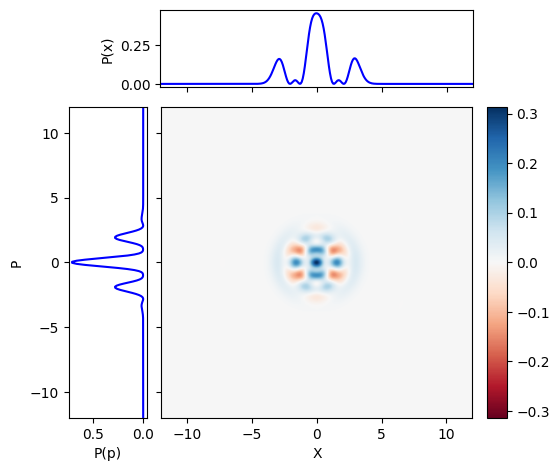

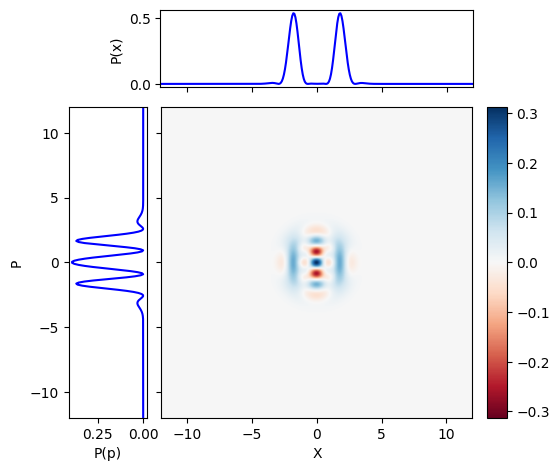

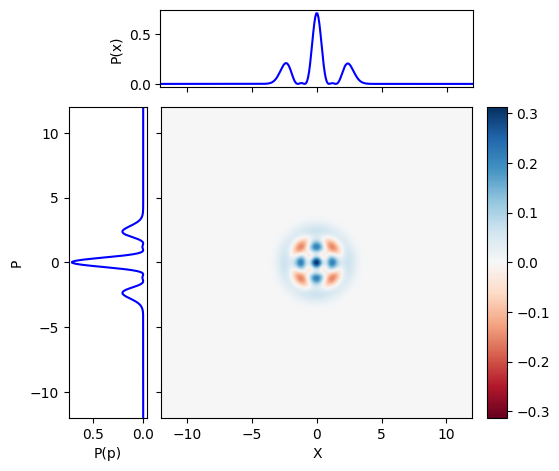

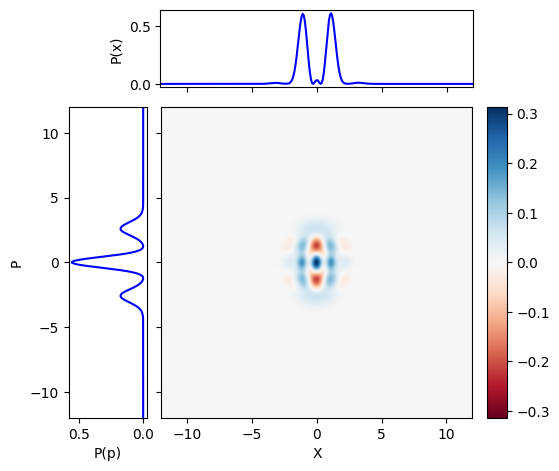

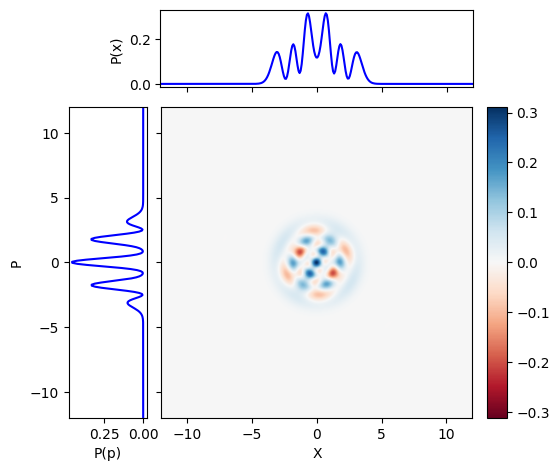

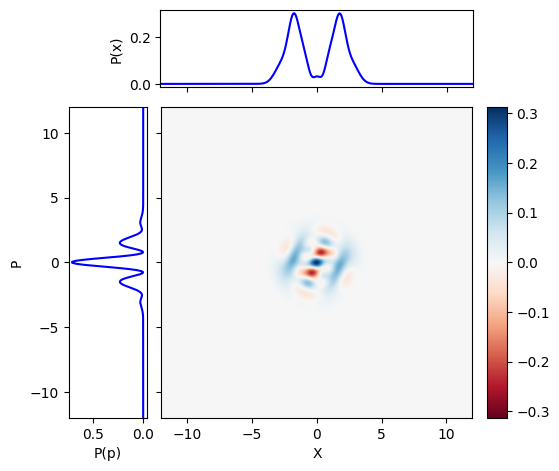

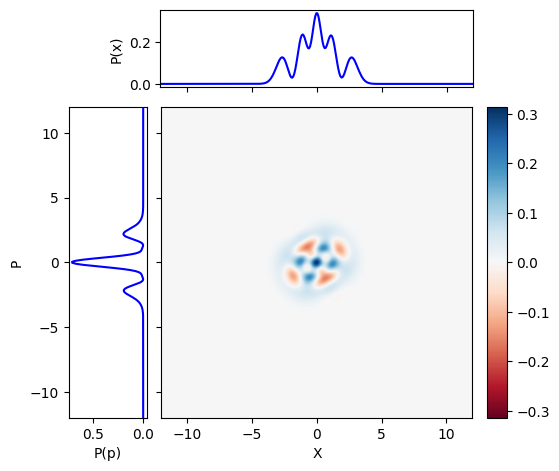

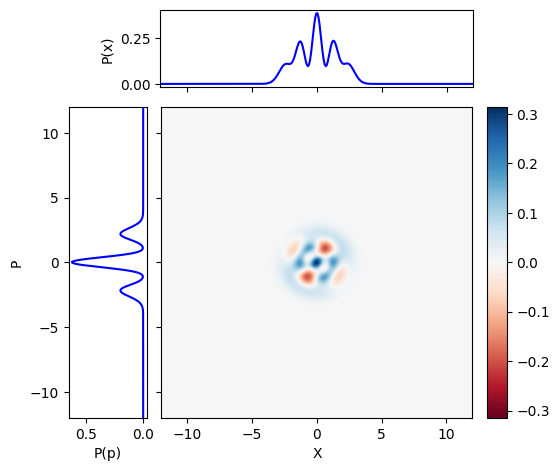

In [66]:
n = 6
lattices = ['0', '1', 's0', 's1', 'h0', 'h1', 'hs0', 'hs1']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']
for i, lattice in enumerate(lattices):
    
    print_test(n, lattice)